In [41]:
import pandas as pd
import sys
import os
import random

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [42]:
import warnings

warnings.filterwarnings("ignore")

In [43]:
sys.path.append("../")
from feature_engineering import feature_engineering
from data_loader import lgbm_data_loader

In [44]:
IS_CUSTOM = True
USE_VALID = True
valid_len = 1
DROPS = [
    "assessmentItemID",
    "testId",
    "Timestamp",
    "year",
    "day",
    "minute",
    "second",
]

In [45]:
train, valid, y_train, y_valid, test = lgbm_data_loader(
    IS_CUSTOM=IS_CUSTOM, USE_VALID=USE_VALID, DROPS=DROPS, valid_len=valid_len
)
lgb_train = lgb.Dataset(train, y_train)
lgb_valid = lgb.Dataset(valid, y_valid)

In [46]:
train.shape, valid.shape, test.shape

((2471510, 8), (3720, 8), (744, 9))

## 1. 데이터 로딩

## 2. Feature Engineering

## 3. Train/Test 데이터 셋 분리

In [47]:
# # train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
# random.seed(42)


# def custom_train_test_split(df, ratio=0.7, split=True):

#     users = list(zip(df["userID"].value_counts().index, df["userID"].value_counts()))
#     random.shuffle(users)

#     max_train_data_len = ratio * len(df)
#     sum_of_train_data = 0
#     user_ids = []

#     for user_id, count in users:
#         sum_of_train_data += count
#         if max_train_data_len < sum_of_train_data:
#             break
#         user_ids.append(user_id)

#     train = df[df["userID"].isin(user_ids)]
#     test = df[df["userID"].isin(user_ids) == False]

#     # test데이터셋은 각 유저의 마지막 interaction만 추출
#     test = test[test["userID"] != test["userID"].shift(-1)]
#     return train, test
# 유저별 분리
# train, test = custom_train_test_split(df)

# X, y 값 분리

## 4. 훈련 및 검증

In [62]:
"""
{'bagging_fraction': 0.62, 'seed': 42, 'lr': 0.1, 'n_iter': 200, 'max_depth': -1, 'patience': 5, 'feature_fraction': 0.75, 'num_leaves': 400}
"""
params = {
    "objective": "binary",
    "bagging_fraction": 0.52,
    "seed": 42,
    "lr": 0.001,
    "n_iter": 10000,
    "max_depth": -1,
    "patience": 250,
    "feature_fraction": 0.57,
    "num_leaves": 500,
    # "bagging_fraction": 0.62,
    # "bagging_seed": 11,
    # "learning_rate": 0.1,
    # "num_iterations": 1000,
    # "max_depth": -1,
    # "boosting": "gbdt",
    # "early_stopping": 35,
    # "feature_fraction": 0.75,
    # "num_leaves": 400,
    "min_child_weight": 0.03454472573214212,
    "reg_alpha": 0.3899927210061127,
    "reg_lambda": 0.6485237330340494,
    "random_state": 42,
    "metric": "auc",
    "verbosity": -1,
}
valid_sets = [lgb_train, lgb_valid] if USE_VALID else [lgb_train]
model = lgb.train(
    params,
    lgb_valid,
    valid_sets=valid_sets,
    verbose_eval=100,
    num_boost_round=500,
    early_stopping_rounds=1000,
)

Training until validation scores don't improve for 1000 rounds
[100]	training's auc: 0.986098	valid_0's auc: 0.604153
[200]	training's auc: 0.998729	valid_0's auc: 0.598227
[300]	training's auc: 0.999848	valid_0's auc: 0.59525
[400]	training's auc: 0.999977	valid_0's auc: 0.592396
[500]	training's auc: 0.999998	valid_0's auc: 0.591465
[600]	training's auc: 1	valid_0's auc: 0.590452
[700]	training's auc: 1	valid_0's auc: 0.59052
[800]	training's auc: 1	valid_0's auc: 0.59052
[900]	training's auc: 1	valid_0's auc: 0.59052
[1000]	training's auc: 1	valid_0's auc: 0.59052
Early stopping, best iteration is:
[10]	training's auc: 0.876056	valid_0's auc: 0.620377


In [63]:
preds = model.predict(valid)
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)
acc, auc

(0.7438172043010752, 0.8760557455822385)

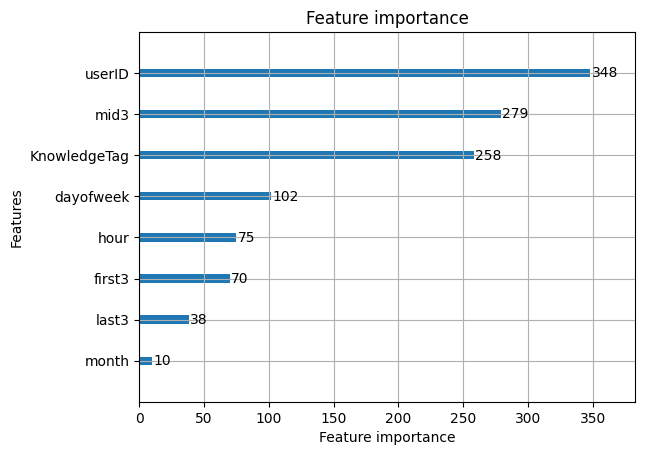

In [64]:
_ = lgb.plot_importance(model)

## 5. Inference

In [68]:
T  # LOAD TESTDAA

# FEATURE ENGINEERING

# LEAVE LAST INTERACTION ONLY

# DROP ANSWERCODE
test_df = test.drop(["answerCode"], axis=1)

In [69]:
# MAKE PREDICTION
total_preds = model.predict(test_df)
ans = pd.read_csv("/opt/ml/input/data/custom_answer.csv")["prediction"]
acc = accuracy_score(ans.values, np.where(total_preds >= 0.5, 1, 0))
auc = roc_auc_score(ans.values, total_preds)
acc, auc

(0.6491935483870968, 0.726977462089347)

In [70]:
# SAVE OUTPUT
output_dir = "output/"
write_path = os.path.join(output_dir, "lgbm_submission.csv")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, "w", encoding="utf8") as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write("{},{}\n".format(id, p))

writing prediction : output/lgbm_submission.csv


### Optuna example

In [14]:
# {'bagging_fraction': 0.61, 'seed': 11, 'lr': 0.1, 'n_iter': 1000, 'max_depth': 2, 'patience': 35, 'feature_fraction': 0.56, 'num_leaves': 150}

In [22]:
def objective(trial: Trial):
    params = {
        "objective": "binary",
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.5, 0.8, step=0.01
        ),
        "bagging_seed": trial.suggest_categorical("seed", [11, 42]),  ##
        "learning_rate": trial.suggest_categorical(
            "lr", [0.0001, 0.0005, 0.001, 0.005, 0.01]
        ),
        "num_iterations": trial.suggest_int("n_iter", 1000, 2000, 3000),
        "max_depth": trial.suggest_categorical("max_depth", [-1]),  # need to consider
        "boosting": "gbdt",
        "early_stopping": trial.suggest_int("patience", 5, 40, 5),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.5, 0.8, step=0.01
        ),
        "num_leaves": trial.suggest_int("num_leaves", 100, 500, 50),
        "min_child_weight": 0.03454472573214212,
        "reg_alpha": 0.3899927210061127,
        "reg_lambda": 0.6485237330340494,
        "random_state": 47,
        "metric": "auc",
        "verbosity": -1,
    }
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_valid],
        verbose_eval=500,
        num_boost_round=500,
        early_stopping_rounds=100,
    )

    preds = model.predict(valid)
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)

    return auc


if USE_VALID and IS_CUSTOM:
    sampler = TPESampler(seed=42)
    study = optuna.create_study(
        study_name="lgbm_parameter_opt",
        direction="maximize",
        sampler=sampler,
    )
    study.optimize(objective, n_trials=1500)
    print("Best Score:", study.best_value)
    print("Best trial:", study.best_trial.params)

[I 2022-12-02 17:51:30,455] A new study created in memory with name: lgbm_parameter_opt


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.704409	valid_1's auc: 0.690241
[1000]	training's auc: 0.718502	valid_1's auc: 0.703954
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.718502	valid_1's auc: 0.703954


[I 2022-12-02 17:55:32,925] Trial 0 finished with value: 0.7039538302855898 and parameters: {'bagging_fraction': 0.61, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.71, 'num_leaves': 100}. Best is trial 0 with value: 0.7039538302855898.


Training until validation scores don't improve for 15 rounds


[I 2022-12-02 17:55:38,756] Trial 1 finished with value: 0.6747958973929762 and parameters: {'bagging_fraction': 0.8, 'seed': 11, 'lr': 0.005, 'n_iter': 1000, 'max_depth': -1, 'patience': 15, 'feature_fraction': 0.6799999999999999, 'num_leaves': 150}. Best is trial 0 with value: 0.7039538302855898.


Early stopping, best iteration is:
[9]	training's auc: 0.684775	valid_1's auc: 0.674796
Training until validation scores don't improve for 25 rounds


[I 2022-12-02 17:55:45,908] Trial 2 finished with value: 0.6716075826595558 and parameters: {'bagging_fraction': 0.59, 'seed': 42, 'lr': 0.0001, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.55, 'num_leaves': 100}. Best is trial 0 with value: 0.7039538302855898.


Early stopping, best iteration is:
[5]	training's auc: 0.67835	valid_1's auc: 0.671608
Training until validation scores don't improve for 20 rounds


[I 2022-12-02 17:55:53,409] Trial 3 finished with value: 0.693380835217531 and parameters: {'bagging_fraction': 0.79, 'seed': 11, 'lr': 0.001, 'n_iter': 1000, 'max_depth': -1, 'patience': 20, 'feature_fraction': 0.51, 'num_leaves': 500}. Best is trial 0 with value: 0.7039538302855898.


Early stopping, best iteration is:
[5]	training's auc: 0.700186	valid_1's auc: 0.693381
Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.716679	valid_1's auc: 0.703042
[1000]	training's auc: 0.731383	valid_1's auc: 0.715298
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.731383	valid_1's auc: 0.715298


[I 2022-12-02 18:00:07,000] Trial 4 finished with value: 0.7152976334805818 and parameters: {'bagging_fraction': 0.58, 'seed': 11, 'lr': 0.005, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.77, 'num_leaves': 350}. Best is trial 4 with value: 0.7152976334805818.


Training until validation scores don't improve for 15 rounds


[I 2022-12-02 18:00:11,842] Trial 5 finished with value: 0.6838006594794322 and parameters: {'bagging_fraction': 0.78, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 15, 'feature_fraction': 0.58, 'num_leaves': 300}. Best is trial 4 with value: 0.7152976334805818.


Early stopping, best iteration is:
[9]	training's auc: 0.695212	valid_1's auc: 0.683801
Training until validation scores don't improve for 30 rounds


[I 2022-12-02 18:00:22,430] Trial 6 finished with value: 0.686643418314032 and parameters: {'bagging_fraction': 0.54, 'seed': 11, 'lr': 0.0001, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.72, 'num_leaves': 400}. Best is trial 4 with value: 0.7152976334805818.


Early stopping, best iteration is:
[20]	training's auc: 0.700373	valid_1's auc: 0.686643
Training until validation scores don't improve for 15 rounds


[I 2022-12-02 18:00:29,292] Trial 7 finished with value: 0.6847522459594884 and parameters: {'bagging_fraction': 0.52, 'seed': 11, 'lr': 0.0001, 'n_iter': 1000, 'max_depth': -1, 'patience': 15, 'feature_fraction': 0.72, 'num_leaves': 350}. Best is trial 4 with value: 0.7152976334805818.


Early stopping, best iteration is:
[20]	training's auc: 0.698185	valid_1's auc: 0.684752
Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.694166	valid_1's auc: 0.681178
[1000]	training's auc: 0.704064	valid_1's auc: 0.689946
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.704064	valid_1's auc: 0.689946


[I 2022-12-02 18:04:08,052] Trial 8 finished with value: 0.6899463542160282 and parameters: {'bagging_fraction': 0.77, 'seed': 11, 'lr': 0.005, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.63, 'num_leaves': 100}. Best is trial 4 with value: 0.7152976334805818.


Training until validation scores don't improve for 35 rounds


[I 2022-12-02 18:04:40,950] Trial 9 finished with value: 0.6719688316579666 and parameters: {'bagging_fraction': 0.53, 'seed': 42, 'lr': 0.001, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.5700000000000001, 'num_leaves': 100}. Best is trial 4 with value: 0.7152976334805818.


Early stopping, best iteration is:
[135]	training's auc: 0.682035	valid_1's auc: 0.671969
Training until validation scores don't improve for 40 rounds


[I 2022-12-02 18:04:52,696] Trial 10 finished with value: 0.6788370243913846 and parameters: {'bagging_fraction': 0.72, 'seed': 11, 'lr': 0.0005, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.8, 'num_leaves': 250}. Best is trial 4 with value: 0.7152976334805818.


Early stopping, best iteration is:
[20]	training's auc: 0.692985	valid_1's auc: 0.678837
Training until validation scores don't improve for 5 rounds


[I 2022-12-02 18:04:57,704] Trial 11 finished with value: 0.6777388151279019 and parameters: {'bagging_fraction': 0.63, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 5, 'feature_fraction': 0.8, 'num_leaves': 200}. Best is trial 4 with value: 0.7152976334805818.


Early stopping, best iteration is:
[20]	training's auc: 0.691308	valid_1's auc: 0.677739
Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.737615	valid_1's auc: 0.720525
[1000]	training's auc: 0.758713	valid_1's auc: 0.734496
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.758713	valid_1's auc: 0.734496


[I 2022-12-02 18:09:02,594] Trial 12 finished with value: 0.7344964484361672 and parameters: {'bagging_fraction': 0.65, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.74, 'num_leaves': 450}. Best is trial 12 with value: 0.7344964484361672.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.722149	valid_1's auc: 0.708481
[1000]	training's auc: 0.737588	valid_1's auc: 0.720396
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.737588	valid_1's auc: 0.720396


[I 2022-12-02 18:13:05,940] Trial 13 finished with value: 0.7203957368925694 and parameters: {'bagging_fraction': 0.6799999999999999, 'seed': 11, 'lr': 0.005, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.76, 'num_leaves': 450}. Best is trial 12 with value: 0.7344964484361672.


Training until validation scores don't improve for 35 rounds


[I 2022-12-02 18:13:16,057] Trial 14 finished with value: 0.6912759597715084 and parameters: {'bagging_fraction': 0.69, 'seed': 42, 'lr': 0.0005, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.76, 'num_leaves': 500}. Best is trial 12 with value: 0.7344964484361672.


Early stopping, best iteration is:
[12]	training's auc: 0.703318	valid_1's auc: 0.691276
Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.737221	valid_1's auc: 0.721691
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286


[I 2022-12-02 18:17:33,367] Trial 15 finished with value: 0.7352860267410417 and parameters: {'bagging_fraction': 0.67, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.64, 'num_leaves': 450}. Best is trial 15 with value: 0.7352860267410417.


Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.737221	valid_1's auc: 0.721691
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286


[I 2022-12-02 18:21:36,397] Trial 16 finished with value: 0.7352860267410417 and parameters: {'bagging_fraction': 0.66, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.63, 'num_leaves': 450}. Best is trial 15 with value: 0.7352860267410417.


Training until validation scores don't improve for 30 rounds
[500]	training's auc: 0.734232	valid_1's auc: 0.719214
[1000]	training's auc: 0.753387	valid_1's auc: 0.732751
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.753387	valid_1's auc: 0.732751


[I 2022-12-02 18:26:07,218] Trial 17 finished with value: 0.7327514373032978 and parameters: {'bagging_fraction': 0.73, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.64, 'num_leaves': 400}. Best is trial 15 with value: 0.7352860267410417.


Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.737221	valid_1's auc: 0.721691
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286


[I 2022-12-02 18:30:12,362] Trial 18 finished with value: 0.7352860267410417 and parameters: {'bagging_fraction': 0.6799999999999999, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.61, 'num_leaves': 450}. Best is trial 15 with value: 0.7352860267410417.


Training until validation scores don't improve for 30 rounds
[500]	training's auc: 0.730792	valid_1's auc: 0.716725
[1000]	training's auc: 0.749646	valid_1's auc: 0.730853
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.749646	valid_1's auc: 0.730853


[I 2022-12-02 18:34:15,141] Trial 19 finished with value: 0.7308528799607119 and parameters: {'bagging_fraction': 0.72, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.6, 'num_leaves': 350}. Best is trial 15 with value: 0.7352860267410417.


Training until validation scores don't improve for 5 rounds


[I 2022-12-02 18:34:19,105] Trial 20 finished with value: 0.6876754703929675 and parameters: {'bagging_fraction': 0.65, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 5, 'feature_fraction': 0.67, 'num_leaves': 400}. Best is trial 15 with value: 0.7352860267410417.


Early stopping, best iteration is:
[13]	training's auc: 0.700732	valid_1's auc: 0.687675
Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.737221	valid_1's auc: 0.721691
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286


[I 2022-12-02 18:38:53,297] Trial 21 finished with value: 0.7352860267410417 and parameters: {'bagging_fraction': 0.69, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.6, 'num_leaves': 450}. Best is trial 15 with value: 0.7352860267410417.


Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 18:43:00,043] Trial 22 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.7, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.61, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 30 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 18:47:08,337] Trial 23 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.75, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.61, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 30 rounds


[I 2022-12-02 18:47:17,983] Trial 24 finished with value: 0.693765777719245 and parameters: {'bagging_fraction': 0.75, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.53, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[5]	training's auc: 0.700334	valid_1's auc: 0.693766
Training until validation scores don't improve for 30 rounds


[I 2022-12-02 18:47:26,737] Trial 25 finished with value: 0.6935457666171462 and parameters: {'bagging_fraction': 0.7, 'seed': 42, 'lr': 0.001, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.59, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[9]	training's auc: 0.70308	valid_1's auc: 0.693546
Training until validation scores don't improve for 20 rounds


[I 2022-12-02 18:47:32,312] Trial 26 finished with value: 0.6933796043861905 and parameters: {'bagging_fraction': 0.75, 'seed': 42, 'lr': 0.0005, 'n_iter': 1000, 'max_depth': -1, 'patience': 20, 'feature_fraction': 0.56, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[5]	training's auc: 0.700183	valid_1's auc: 0.69338
Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.734232	valid_1's auc: 0.719214
[1000]	training's auc: 0.753387	valid_1's auc: 0.732751
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.753387	valid_1's auc: 0.732751


[I 2022-12-02 18:51:39,408] Trial 27 finished with value: 0.7327514373032978 and parameters: {'bagging_fraction': 0.74, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.67, 'num_leaves': 400}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.727093	valid_1's auc: 0.713592
[1000]	training's auc: 0.745027	valid_1's auc: 0.727787
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.745027	valid_1's auc: 0.727787


[I 2022-12-02 18:56:32,496] Trial 28 finished with value: 0.7277865713839098 and parameters: {'bagging_fraction': 0.71, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.61, 'num_leaves': 300}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740423	valid_1's auc: 0.722194
[1000]	training's auc: 0.761974	valid_1's auc: 0.73687
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.761974	valid_1's auc: 0.73687


[I 2022-12-02 19:00:42,527] Trial 29 finished with value: 0.7368704143839875 and parameters: {'bagging_fraction': 0.62, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.69, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 20 rounds
[500]	training's auc: 0.740423	valid_1's auc: 0.722194
[1000]	training's auc: 0.761974	valid_1's auc: 0.73687
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.761974	valid_1's auc: 0.73687


[I 2022-12-02 19:04:47,552] Trial 30 finished with value: 0.7368704143839875 and parameters: {'bagging_fraction': 0.62, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 20, 'feature_fraction': 0.7, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 20 rounds
[500]	training's auc: 0.740423	valid_1's auc: 0.722194
[1000]	training's auc: 0.761974	valid_1's auc: 0.73687
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.761974	valid_1's auc: 0.73687


[I 2022-12-02 19:08:51,354] Trial 31 finished with value: 0.7368704143839875 and parameters: {'bagging_fraction': 0.61, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 20, 'feature_fraction': 0.7, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 10 rounds
[500]	training's auc: 0.740423	valid_1's auc: 0.722194
[1000]	training's auc: 0.761974	valid_1's auc: 0.73687
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.761974	valid_1's auc: 0.73687


[I 2022-12-02 19:12:55,585] Trial 32 finished with value: 0.7368704143839875 and parameters: {'bagging_fraction': 0.59, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 10, 'feature_fraction': 0.7, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 10 rounds


[I 2022-12-02 19:12:59,515] Trial 33 finished with value: 0.690389299644659 and parameters: {'bagging_fraction': 0.56, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 10, 'feature_fraction': 0.65, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[9]	training's auc: 0.701783	valid_1's auc: 0.690389
Training until validation scores don't improve for 25 rounds


[I 2022-12-02 19:13:06,949] Trial 34 finished with value: 0.6937194676900618 and parameters: {'bagging_fraction': 0.5, 'seed': 42, 'lr': 0.0001, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.6799999999999999, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[9]	training's auc: 0.703032	valid_1's auc: 0.693719
Training until validation scores don't improve for 10 rounds


[I 2022-12-02 19:13:11,525] Trial 35 finished with value: 0.6888307594598619 and parameters: {'bagging_fraction': 0.59, 'seed': 42, 'lr': 0.001, 'n_iter': 1000, 'max_depth': -1, 'patience': 10, 'feature_fraction': 0.66, 'num_leaves': 400}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[12]	training's auc: 0.699619	valid_1's auc: 0.688831
Training until validation scores don't improve for 10 rounds


[I 2022-12-02 19:13:15,037] Trial 36 finished with value: 0.693765777719245 and parameters: {'bagging_fraction': 0.59, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 10, 'feature_fraction': 0.54, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[5]	training's auc: 0.700334	valid_1's auc: 0.693766
Training until validation scores don't improve for 15 rounds


[I 2022-12-02 19:13:20,795] Trial 37 finished with value: 0.6893310923997396 and parameters: {'bagging_fraction': 0.5700000000000001, 'seed': 42, 'lr': 0.005, 'n_iter': 1000, 'max_depth': -1, 'patience': 15, 'feature_fraction': 0.73, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[12]	training's auc: 0.701874	valid_1's auc: 0.689331
Training until validation scores don't improve for 10 rounds


[I 2022-12-02 19:13:25,429] Trial 38 finished with value: 0.691107028170037 and parameters: {'bagging_fraction': 0.64, 'seed': 42, 'lr': 0.0001, 'n_iter': 1000, 'max_depth': -1, 'patience': 10, 'feature_fraction': 0.69, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[12]	training's auc: 0.703264	valid_1's auc: 0.691107
Training until validation scores don't improve for 20 rounds


[I 2022-12-02 19:13:30,571] Trial 39 finished with value: 0.6805915744671424 and parameters: {'bagging_fraction': 0.8, 'seed': 42, 'lr': 0.0005, 'n_iter': 1000, 'max_depth': -1, 'patience': 20, 'feature_fraction': 0.5, 'num_leaves': 200}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[5]	training's auc: 0.686923	valid_1's auc: 0.680592
Training until validation scores don't improve for 15 rounds
[500]	training's auc: 0.731498	valid_1's auc: 0.715659
[1000]	training's auc: 0.751062	valid_1's auc: 0.72898
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.751062	valid_1's auc: 0.72898


[I 2022-12-02 19:17:22,534] Trial 40 finished with value: 0.7289804777841097 and parameters: {'bagging_fraction': 0.76, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 15, 'feature_fraction': 0.71, 'num_leaves': 350}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 20 rounds
[500]	training's auc: 0.740423	valid_1's auc: 0.722194
[1000]	training's auc: 0.761974	valid_1's auc: 0.73687
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.761974	valid_1's auc: 0.73687


[I 2022-12-02 19:21:49,126] Trial 41 finished with value: 0.7368704143839875 and parameters: {'bagging_fraction': 0.61, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 20, 'feature_fraction': 0.7, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 19:26:25,840] Trial 42 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.61, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.62, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.737221	valid_1's auc: 0.721691
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286


[I 2022-12-02 19:30:29,227] Trial 43 finished with value: 0.7352860267410417 and parameters: {'bagging_fraction': 0.59, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.62, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 19:34:34,439] Trial 44 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.55, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.58, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 30 rounds


[I 2022-12-02 19:34:43,402] Trial 45 finished with value: 0.6912221109003654 and parameters: {'bagging_fraction': 0.54, 'seed': 42, 'lr': 0.001, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.58, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[12]	training's auc: 0.701605	valid_1's auc: 0.691222
Training until validation scores don't improve for 25 rounds


[I 2022-12-02 19:34:50,956] Trial 46 finished with value: 0.6934983796105403 and parameters: {'bagging_fraction': 0.61, 'seed': 42, 'lr': 0.005, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.56, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[5]	training's auc: 0.700131	valid_1's auc: 0.693498
Training until validation scores don't improve for 30 rounds


[I 2022-12-02 19:34:59,834] Trial 47 finished with value: 0.6888313748755321 and parameters: {'bagging_fraction': 0.56, 'seed': 42, 'lr': 0.0001, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.58, 'num_leaves': 400}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[12]	training's auc: 0.699501	valid_1's auc: 0.688831
Training until validation scores don't improve for 20 rounds


[I 2022-12-02 19:35:05,741] Trial 48 finished with value: 0.6838006594794322 and parameters: {'bagging_fraction': 0.63, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 20, 'feature_fraction': 0.62, 'num_leaves': 300}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[9]	training's auc: 0.695212	valid_1's auc: 0.683801
Training until validation scores don't improve for 25 rounds


[I 2022-12-02 19:35:12,779] Trial 49 finished with value: 0.6921040015557709 and parameters: {'bagging_fraction': 0.78, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.52, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[5]	training's auc: 0.698555	valid_1's auc: 0.692104
Training until validation scores don't improve for 30 rounds
[500]	training's auc: 0.711795	valid_1's auc: 0.698287
[1000]	training's auc: 0.726778	valid_1's auc: 0.711301
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.726778	valid_1's auc: 0.711301


[I 2022-12-02 19:38:51,715] Trial 50 finished with value: 0.7113005087025931 and parameters: {'bagging_fraction': 0.5, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.65, 'num_leaves': 150}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 19:42:58,634] Trial 51 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.61, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.59, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 19:47:07,573] Trial 52 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.61, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.59, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.737221	valid_1's auc: 0.721691
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286


[I 2022-12-02 19:51:37,811] Trial 53 finished with value: 0.7352860267410417 and parameters: {'bagging_fraction': 0.66, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.59, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 19:55:54,018] Trial 54 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.55, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.5700000000000001, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds


[I 2022-12-02 19:56:00,907] Trial 55 finished with value: 0.6918047556861331 and parameters: {'bagging_fraction': 0.54, 'seed': 42, 'lr': 0.0005, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.56, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[5]	training's auc: 0.698297	valid_1's auc: 0.691805
Training until validation scores don't improve for 30 rounds


[I 2022-12-02 19:56:10,558] Trial 56 finished with value: 0.693765777719245 and parameters: {'bagging_fraction': 0.5700000000000001, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.54, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[5]	training's auc: 0.700334	valid_1's auc: 0.693766
Training until validation scores don't improve for 30 rounds


[I 2022-12-02 19:56:20,014] Trial 57 finished with value: 0.6918035248547928 and parameters: {'bagging_fraction': 0.64, 'seed': 42, 'lr': 0.005, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.6, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[12]	training's auc: 0.701941	valid_1's auc: 0.691804
Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 20:00:43,521] Trial 58 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.52, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.63, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.734232	valid_1's auc: 0.719214
[1000]	training's auc: 0.753387	valid_1's auc: 0.732751
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.753387	valid_1's auc: 0.732751


[I 2022-12-02 20:04:44,055] Trial 59 finished with value: 0.7327514373032978 and parameters: {'bagging_fraction': 0.52, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.5700000000000001, 'num_leaves': 400}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds


[I 2022-12-02 20:04:55,199] Trial 60 finished with value: 0.6935457666171462 and parameters: {'bagging_fraction': 0.52, 'seed': 42, 'lr': 0.001, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.59, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[9]	training's auc: 0.70308	valid_1's auc: 0.693546
Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 20:09:31,852] Trial 61 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.55, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.63, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 20:13:33,445] Trial 62 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.55, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.63, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 20:17:35,895] Trial 63 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.53, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.63, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.737221	valid_1's auc: 0.721691
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286


[I 2022-12-02 20:22:15,056] Trial 64 finished with value: 0.7352860267410417 and parameters: {'bagging_fraction': 0.51, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.64, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.737221	valid_1's auc: 0.721691
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286


[I 2022-12-02 20:26:26,325] Trial 65 finished with value: 0.7352860267410417 and parameters: {'bagging_fraction': 0.55, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.61, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.722775	valid_1's auc: 0.709599
[1000]	training's auc: 0.739866	valid_1's auc: 0.722987
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.739866	valid_1's auc: 0.722987


[I 2022-12-02 20:30:18,605] Trial 66 finished with value: 0.7229872522798074 and parameters: {'bagging_fraction': 0.53, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.63, 'num_leaves': 250}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 20:34:39,305] Trial 67 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.53, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.63, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 35 rounds


[I 2022-12-02 20:34:51,099] Trial 68 finished with value: 0.6937194676900618 and parameters: {'bagging_fraction': 0.71, 'seed': 11, 'lr': 0.0001, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.5700000000000001, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[9]	training's auc: 0.703032	valid_1's auc: 0.693719
Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.737221	valid_1's auc: 0.721691
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286


[I 2022-12-02 20:39:14,642] Trial 69 finished with value: 0.7352860267410417 and parameters: {'bagging_fraction': 0.5700000000000001, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.62, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 35 rounds


[I 2022-12-02 20:39:24,426] Trial 70 finished with value: 0.6935282272705454 and parameters: {'bagging_fraction': 0.67, 'seed': 11, 'lr': 0.0005, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.6, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[9]	training's auc: 0.703051	valid_1's auc: 0.693528
Training until validation scores don't improve for 30 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 20:43:36,965] Trial 71 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.6, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.61, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 30 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 20:48:03,979] Trial 72 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.6, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.61, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 20:52:29,161] Trial 73 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.58, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.66, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 20:56:56,407] Trial 74 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.58, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.66, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.737221	valid_1's auc: 0.721691
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286


[I 2022-12-02 21:00:58,444] Trial 75 finished with value: 0.7352860267410417 and parameters: {'bagging_fraction': 0.58, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.59, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 21:05:05,544] Trial 76 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.55, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.64, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 20 rounds


[I 2022-12-02 21:05:11,822] Trial 77 finished with value: 0.6933342174805128 and parameters: {'bagging_fraction': 0.51, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 20, 'feature_fraction': 0.58, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[9]	training's auc: 0.703716	valid_1's auc: 0.693334
Training until validation scores don't improve for 40 rounds


[I 2022-12-02 21:05:22,890] Trial 78 finished with value: 0.6937480845187265 and parameters: {'bagging_fraction': 0.55, 'seed': 42, 'lr': 0.005, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.65, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[9]	training's auc: 0.703439	valid_1's auc: 0.693748
Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.737221	valid_1's auc: 0.721691
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286


[I 2022-12-02 21:09:27,648] Trial 79 finished with value: 0.7352860267410417 and parameters: {'bagging_fraction': 0.56, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.62, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds


[I 2022-12-02 21:09:38,819] Trial 80 finished with value: 0.6912221109003654 and parameters: {'bagging_fraction': 0.51, 'seed': 11, 'lr': 0.001, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.63, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[12]	training's auc: 0.701605	valid_1's auc: 0.691222
Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 21:13:50,246] Trial 81 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.53, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.63, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 21:18:27,888] Trial 82 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.53, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.63, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 21:22:36,968] Trial 83 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.54, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.6, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds


[I 2022-12-02 21:22:44,084] Trial 84 finished with value: 0.693765777719245 and parameters: {'bagging_fraction': 0.54, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.55, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[5]	training's auc: 0.700334	valid_1's auc: 0.693766
Training until validation scores don't improve for 20 rounds


[I 2022-12-02 21:22:50,630] Trial 85 finished with value: 0.6933342174805128 and parameters: {'bagging_fraction': 0.55, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 20, 'feature_fraction': 0.6, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[9]	training's auc: 0.703716	valid_1's auc: 0.693334
Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 21:27:14,554] Trial 86 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.56, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.58, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds


[I 2022-12-02 21:27:22,552] Trial 87 finished with value: 0.6913284239573936 and parameters: {'bagging_fraction': 0.63, 'seed': 42, 'lr': 0.0001, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.58, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[12]	training's auc: 0.701513	valid_1's auc: 0.691328
Training until validation scores don't improve for 30 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 21:31:29,338] Trial 88 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.6, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.61, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 20 rounds


[I 2022-12-02 21:31:35,121] Trial 89 finished with value: 0.693765777719245 and parameters: {'bagging_fraction': 0.52, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 20, 'feature_fraction': 0.55, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[5]	training's auc: 0.700334	valid_1's auc: 0.693766
Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.737221	valid_1's auc: 0.721691
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286


[I 2022-12-02 21:35:39,097] Trial 90 finished with value: 0.7352860267410417 and parameters: {'bagging_fraction': 0.5700000000000001, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.67, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 21:40:29,397] Trial 91 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.52, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.62, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 21:44:52,111] Trial 92 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.62, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.64, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 21:49:13,972] Trial 93 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.5, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.64, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 21:53:27,869] Trial 94 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.5, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.65, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 21:57:33,602] Trial 95 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.58, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.66, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 35 rounds


[I 2022-12-02 21:57:43,503] Trial 96 finished with value: 0.6935282272705454 and parameters: {'bagging_fraction': 0.58, 'seed': 42, 'lr': 0.0005, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.66, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[9]	training's auc: 0.703051	valid_1's auc: 0.693528
Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.737221	valid_1's auc: 0.721691
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286


[I 2022-12-02 22:02:00,000] Trial 97 finished with value: 0.7352860267410417 and parameters: {'bagging_fraction': 0.6, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.6799999999999999, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.717106	valid_1's auc: 0.704767
[1000]	training's auc: 0.730879	valid_1's auc: 0.71658
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.730879	valid_1's auc: 0.71658


[I 2022-12-02 22:05:59,602] Trial 98 finished with value: 0.7165804674451266 and parameters: {'bagging_fraction': 0.56, 'seed': 42, 'lr': 0.005, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.66, 'num_leaves': 350}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 30 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 22:10:02,741] Trial 99 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.6, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.61, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 30 rounds


[I 2022-12-02 22:10:11,330] Trial 100 finished with value: 0.680628037845602 and parameters: {'bagging_fraction': 0.6, 'seed': 11, 'lr': 0.001, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.61, 'num_leaves': 250}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[10]	training's auc: 0.691885	valid_1's auc: 0.680628
Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 22:14:49,906] Trial 101 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.73, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.65, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 30 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 22:19:29,730] Trial 102 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.75, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.65, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 22:23:59,402] Trial 103 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.62, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.63, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 30 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 22:28:10,902] Trial 104 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.54, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.59, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 22:32:19,999] Trial 105 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.62, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.62, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 30 rounds
[500]	training's auc: 0.737221	valid_1's auc: 0.721691
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286


[I 2022-12-02 22:36:25,995] Trial 106 finished with value: 0.7352860267410417 and parameters: {'bagging_fraction': 0.53, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.59, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.711795	valid_1's auc: 0.698287
[1000]	training's auc: 0.726778	valid_1's auc: 0.711301
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.726778	valid_1's auc: 0.711301


[I 2022-12-02 22:40:03,053] Trial 107 finished with value: 0.7113005087025931 and parameters: {'bagging_fraction': 0.77, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.61, 'num_leaves': 150}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds


[I 2022-12-02 22:40:15,396] Trial 108 finished with value: 0.6937194676900618 and parameters: {'bagging_fraction': 0.55, 'seed': 11, 'lr': 0.0001, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.62, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[9]	training's auc: 0.703032	valid_1's auc: 0.693719
Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 22:44:51,521] Trial 109 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.54, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.64, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.704133	valid_1's auc: 0.690655
[1000]	training's auc: 0.717465	valid_1's auc: 0.70298
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.717465	valid_1's auc: 0.70298


[I 2022-12-02 22:48:29,887] Trial 110 finished with value: 0.7029799349874886 and parameters: {'bagging_fraction': 0.5700000000000001, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.5700000000000001, 'num_leaves': 100}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 22:52:46,741] Trial 111 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.5, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.64, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 22:56:51,727] Trial 112 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.59, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.64, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 23:00:59,960] Trial 113 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.59, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.66, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 23:05:06,508] Trial 114 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.53, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.64, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 23:09:54,042] Trial 115 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.51, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.6, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.737221	valid_1's auc: 0.721691
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286


[I 2022-12-02 23:14:08,421] Trial 116 finished with value: 0.7352860267410417 and parameters: {'bagging_fraction': 0.51, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.6, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 30 rounds


[I 2022-12-02 23:14:17,645] Trial 117 finished with value: 0.6935282272705454 and parameters: {'bagging_fraction': 0.6, 'seed': 42, 'lr': 0.0005, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.67, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[9]	training's auc: 0.703051	valid_1's auc: 0.693528
Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740423	valid_1's auc: 0.722194
[1000]	training's auc: 0.761974	valid_1's auc: 0.73687
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.761974	valid_1's auc: 0.73687


[I 2022-12-02 23:18:27,250] Trial 118 finished with value: 0.7368704143839875 and parameters: {'bagging_fraction': 0.52, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.78, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.737221	valid_1's auc: 0.721691
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286


[I 2022-12-02 23:22:29,363] Trial 119 finished with value: 0.7352860267410417 and parameters: {'bagging_fraction': 0.5, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.65, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 23:26:35,328] Trial 120 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.7, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.6799999999999999, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 23:30:39,765] Trial 121 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.61, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.6799999999999999, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 23:34:44,366] Trial 122 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.61, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.58, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 23:39:27,652] Trial 123 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.58, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.63, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 23:43:40,657] Trial 124 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.56, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.63, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 23:47:55,687] Trial 125 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.58, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.63, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 23:52:08,668] Trial 126 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.56, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.62, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds


[I 2022-12-02 23:52:19,888] Trial 127 finished with value: 0.6918035248547928 and parameters: {'bagging_fraction': 0.53, 'seed': 11, 'lr': 0.005, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.61, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[12]	training's auc: 0.701941	valid_1's auc: 0.691804
Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-02 23:57:06,548] Trial 128 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.73, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.65, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds


[I 2022-12-02 23:57:51,749] Trial 129 finished with value: 0.6802377104567738 and parameters: {'bagging_fraction': 0.5, 'seed': 11, 'lr': 0.001, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.62, 'num_leaves': 200}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[146]	training's auc: 0.691212	valid_1's auc: 0.680238
Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 00:02:24,828] Trial 130 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.76, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.64, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 00:06:49,644] Trial 131 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.54, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.64, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 00:11:21,782] Trial 132 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.54, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.64, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 30 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 00:15:43,231] Trial 133 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.63, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.59, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 30 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 00:19:48,537] Trial 134 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.63, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.59, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 00:23:54,213] Trial 135 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.53, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.66, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 00:27:58,417] Trial 136 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.51, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.67, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 30 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 00:32:12,128] Trial 137 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.64, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.65, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 30 rounds
[500]	training's auc: 0.737221	valid_1's auc: 0.721691
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286


[I 2022-12-03 00:36:47,973] Trial 138 finished with value: 0.7352860267410417 and parameters: {'bagging_fraction': 0.64, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.62, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 30 rounds


[I 2022-12-03 00:36:55,727] Trial 139 finished with value: 0.6837989670863391 and parameters: {'bagging_fraction': 0.74, 'seed': 11, 'lr': 0.0001, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.65, 'num_leaves': 300}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[10]	training's auc: 0.694615	valid_1's auc: 0.683799
Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 00:41:34,924] Trial 140 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.59, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.64, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 00:45:43,458] Trial 141 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.55, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.63, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds


[I 2022-12-03 00:45:50,568] Trial 142 finished with value: 0.693765777719245 and parameters: {'bagging_fraction': 0.62, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.56, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[5]	training's auc: 0.700334	valid_1's auc: 0.693766
Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 00:49:56,272] Trial 143 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.52, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.5700000000000001, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 30 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 00:54:02,278] Trial 144 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.6, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 30, 'feature_fraction': 0.65, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 00:58:13,927] Trial 145 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.76, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.61, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 01:02:13,438] Trial 146 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.62, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.61, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 35 rounds


[I 2022-12-03 01:02:25,226] Trial 147 finished with value: 0.6935282272705454 and parameters: {'bagging_fraction': 0.79, 'seed': 11, 'lr': 0.0005, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.66, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[9]	training's auc: 0.703051	valid_1's auc: 0.693528
Training until validation scores don't improve for 15 rounds


[I 2022-12-03 01:02:31,928] Trial 148 finished with value: 0.6933342174805128 and parameters: {'bagging_fraction': 0.5700000000000001, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 15, 'feature_fraction': 0.66, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[9]	training's auc: 0.703716	valid_1's auc: 0.693334
Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 01:07:13,856] Trial 149 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.61, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.6799999999999999, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 01:11:21,226] Trial 150 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.62, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.6, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 01:15:40,248] Trial 151 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.62, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.58, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 01:19:46,066] Trial 152 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.62, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.58, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 01:23:56,610] Trial 153 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.54, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.65, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 01:28:34,830] Trial 154 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.74, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.62, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 01:32:57,316] Trial 155 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.72, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.6799999999999999, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds


[I 2022-12-03 01:33:08,925] Trial 156 finished with value: 0.6913145771048139 and parameters: {'bagging_fraction': 0.71, 'seed': 42, 'lr': 0.005, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.69, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[12]	training's auc: 0.703709	valid_1's auc: 0.691315
Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.737615	valid_1's auc: 0.720525
[1000]	training's auc: 0.758713	valid_1's auc: 0.734496
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.758713	valid_1's auc: 0.734496


[I 2022-12-03 01:37:23,299] Trial 157 finished with value: 0.7344964484361672 and parameters: {'bagging_fraction': 0.58, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.71, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 35 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 01:41:56,780] Trial 158 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.61, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 35, 'feature_fraction': 0.63, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds


[I 2022-12-03 01:42:06,170] Trial 159 finished with value: 0.6935457666171462 and parameters: {'bagging_fraction': 0.65, 'seed': 11, 'lr': 0.001, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.64, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[9]	training's auc: 0.70308	valid_1's auc: 0.693546
Training until validation scores don't improve for 20 rounds


[I 2022-12-03 01:42:13,972] Trial 160 finished with value: 0.6933342174805128 and parameters: {'bagging_fraction': 0.58, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 20, 'feature_fraction': 0.6, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[9]	training's auc: 0.703716	valid_1's auc: 0.693334
Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 01:46:36,401] Trial 161 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.51, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.67, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds


[I 2022-12-03 01:46:43,822] Trial 162 finished with value: 0.693765777719245 and parameters: {'bagging_fraction': 0.56, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.56, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[5]	training's auc: 0.700334	valid_1's auc: 0.693766
Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 01:50:46,836] Trial 163 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.59, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.62, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 01:54:54,690] Trial 164 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.5, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.64, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 01:59:04,556] Trial 165 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.5, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.64, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 02:03:42,032] Trial 166 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.51, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.65, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740423	valid_1's auc: 0.722194
[1000]	training's auc: 0.761974	valid_1's auc: 0.73687
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.761974	valid_1's auc: 0.73687


[I 2022-12-03 02:07:55,063] Trial 167 finished with value: 0.7368704143839875 and parameters: {'bagging_fraction': 0.73, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.69, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.737221	valid_1's auc: 0.721691
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.75725	valid_1's auc: 0.735286


[I 2022-12-03 02:12:31,078] Trial 168 finished with value: 0.7352860267410417 and parameters: {'bagging_fraction': 0.61, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.59, 'num_leaves': 450}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 02:16:39,729] Trial 169 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.56, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.63, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds


[I 2022-12-03 02:16:51,049] Trial 170 finished with value: 0.6937194676900618 and parameters: {'bagging_fraction': 0.5700000000000001, 'seed': 42, 'lr': 0.0001, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.63, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Early stopping, best iteration is:
[9]	training's auc: 0.703032	valid_1's auc: 0.693719
Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.730792	valid_1's auc: 0.716725
[1000]	training's auc: 0.749646	valid_1's auc: 0.730853
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.749646	valid_1's auc: 0.730853


[I 2022-12-03 02:20:47,717] Trial 171 finished with value: 0.7308528799607119 and parameters: {'bagging_fraction': 0.54, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.63, 'num_leaves': 350}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 02:24:55,034] Trial 172 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.56, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.64, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 02:29:04,170] Trial 173 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.66, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.67, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 02:33:33,225] Trial 174 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.6, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.66, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 40 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 02:37:44,530] Trial 175 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.53, 'seed': 11, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 40, 'feature_fraction': 0.63, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.760505	valid_1's auc: 0.737145


[I 2022-12-03 02:41:57,796] Trial 176 finished with value: 0.7371448897728994 and parameters: {'bagging_fraction': 0.52, 'seed': 42, 'lr': 0.01, 'n_iter': 1000, 'max_depth': -1, 'patience': 25, 'feature_fraction': 0.5700000000000001, 'num_leaves': 500}. Best is trial 22 with value: 0.7371448897728994.


Training until validation scores don't improve for 30 rounds
[500]	training's auc: 0.740142	valid_1's auc: 0.724264


[W 2022-12-03 02:45:34,708] Trial 177 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/opt/conda/envs/lgbm/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_26233/4044801079.py", line 20, in objective
    model = lgb.train(
  File "/opt/conda/envs/lgbm/lib/python3.10/site-packages/lightgbm/engine.py", line 298, in train
    evaluation_result_list.extend(booster.eval_train(feval))
  File "/opt/conda/envs/lgbm/lib/python3.10/site-packages/lightgbm/basic.py", line 3238, in eval_train
    return self.__inner_eval(self._train_data_name, 0, feval)
  File "/opt/conda/envs/lgbm/lib/python3.10/site-packages/lightgbm/basic.py", line 3789, in __inner_eval
    _safe_call(_LIB.LGBM_BoosterGetEval(
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
import pickle

# save data
with open("best_param.pickle", "wb") as fw:
    pickle.dump(study.best_trial.params, fw)